# Assess & Clean Data

Load raw data, assess, clean and save in proper sets.


### Data Sources

Cleaned datafiles, as prepared in notebook 1:
- portfolio_clean.csv - containing offer ids and meta data about each offer (duration, type, etc.)
- profile_clean.csv - demographic data for each customer
- transcript_clean.csv - records for transactions, offers received, offers viewed, and offers completed

### Changes

- 2019-01-08: Started notebook



In [28]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [35]:
# import data

portfolio_file = Path.cwd() / "data" / "processed" / "portfolio_clean.csv"
profile_file = Path.cwd() / "data" / "processed" / "profile_clean.csv"
transcript_file = Path.cwd() / "data" / "processed" / "transcript_clean.csv"

portfolio = pd.read_csv(portfolio_file, index_col = 0)
profile = pd.read_csv(profile_file, index_col = 0)
transcript = pd.read_csv(transcript_file)

## Explore portfolio data

In [43]:
display(portfolio)
display(portfolio.info())

,difficulty,duration,offer_type,reward,web,email,mobile,social,prop_rewards,rel_difficulty,duration_hours,offer_received,offer_viewed,offer_completed,view_to_complete
offer_id,,,,,,,,,,,,,,,
o_1,10,7,bogo,10,0.0,1.0,1.0,1.0,1.000000,1.428571,168,7658,6675,3649,0.546667
o_2,10,5,bogo,10,1.0,1.0,1.0,1.0,1.000000,2.000000,120,7593,7218,3272,0.453311
o_3,5,7,bogo,5,1.0,1.0,1.0,0.0,1.000000,0.714286,168,7677,4122,4302,1.043668
o_4,5,5,bogo,5,1.0,1.0,1.0,1.0,1.000000,1.000000,120,7571,7191,4208,0.585176
o_5,20,10,discount,5,1.0,1.0,0.0,0.0,0.250000,2.000000,240,7668,2651,3390,1.278763
o_6,7,7,discount,3,1.0,1.0,1.0,1.0,0.428571,1.000000,168,7646,7329,5108,0.696957
o_7,10,10,discount,2,1.0,1.0,1.0,1.0,0.200000,1.000000,240,7597,7326,5296,0.722905
o_8,10,7,discount,2,1.0,1.0,1.0,0.0,0.200000,1.428571,168,7632,4056,3963,0.977071
o_9,0,4,informational,0,1.0,1.0,1.0,0.0,NaN,0.000000,96,7617,3752,0,0.000000


<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, o_1 to o_10
Data columns (total 15 columns):
difficulty          10 non-null int64
duration            10 non-null int64
offer_type          10 non-null object
reward              10 non-null int64
web                 10 non-null float64
email               10 non-null float64
mobile              10 non-null float64
social              10 non-null float64
prop_rewards        8 non-null float64
rel_difficulty      10 non-null float64
duration_hours      10 non-null int64
offer_received      10 non-null int64
offer_viewed        10 non-null int64
offer_completed     10 non-null int64
view_to_complete    10 non-null float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.2+ KB


None

In [44]:
# change some columns to type category
portfolio = cleaning.change_dtypes(portfolio, cols_to_category=['offer_type', 'web', 'email', 'mobile', 'social'])

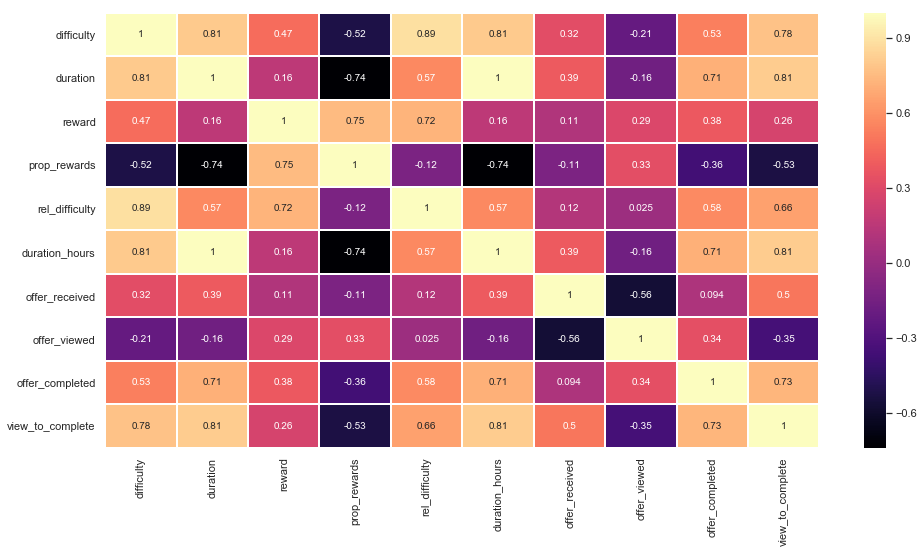

In [47]:
"""show correlation between numerical features"""

EDA.plot_num_corrMap(portfolio,  figsize=(16, 8))

## Explore profile data

In [34]:
display(profile.head())
display(profile.info())

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,transactions,total_amount
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,9.0,20.40
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,6.0,15.62
p_100,68.0,F,84000.0,-725,5.0,NaN,1.0,2.0,34.04
p_1000,67.0,M,44000.0,-225,4.0,4.0,NaN,5.0,19.78
p_10000,NaN,NaN,NaN,-446,3.0,3.0,NaN,6.0,7.28


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 9 columns):
age                14825 non-null float64
gender             14825 non-null object
income             14825 non-null float64
member_days        17000 non-null int64
offer_received     16994 non-null float64
offer_viewed       16834 non-null float64
offer_completed    12774 non-null float64
transactions       16578 non-null float64
total_amount       17000 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.3+ MB


None

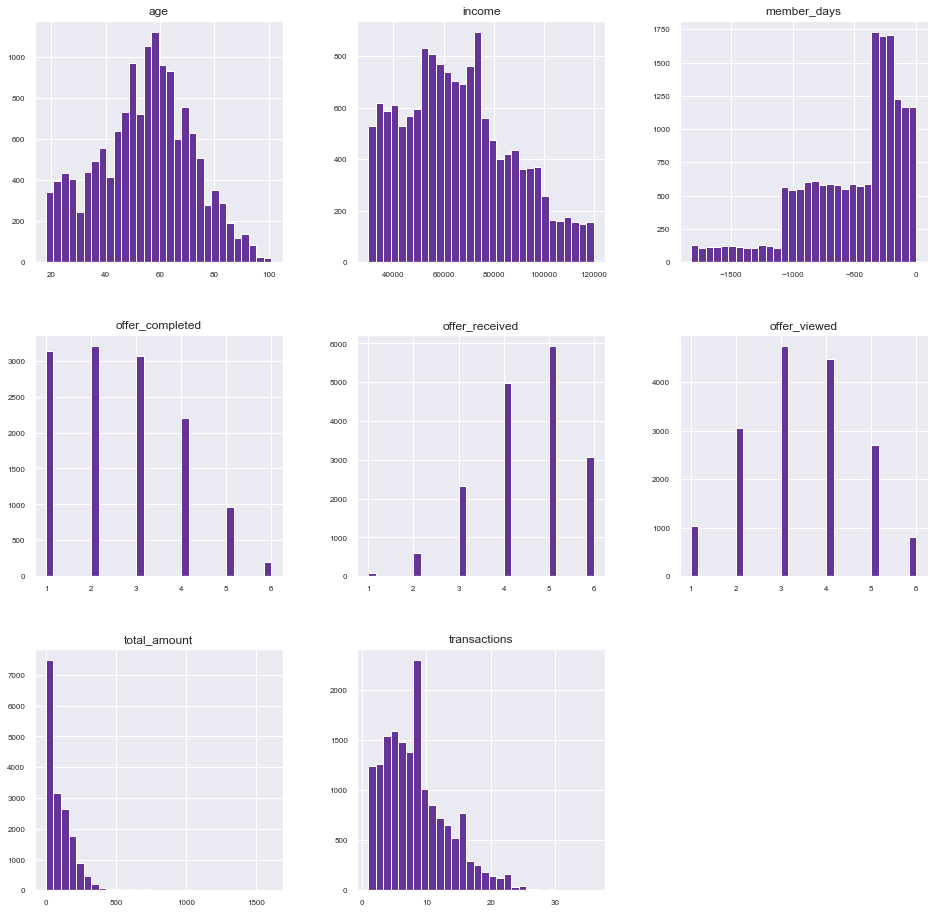

In [35]:
"""plot histograms of numerical data""" # note socio-demographic features missing for 2'175 customers

EDA.plot_num_hist(profile, figsize=(16, 16), bins=30)

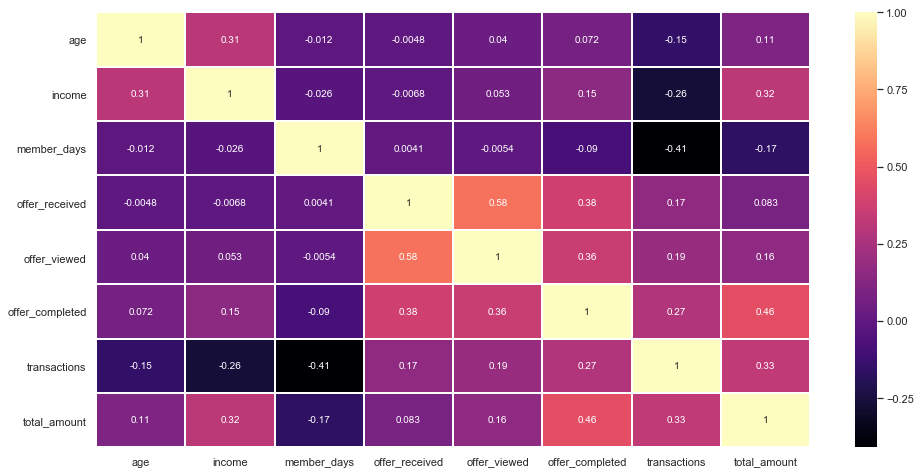

In [39]:
"""show correlation between numerical features"""

EDA.plot_num_corrMap(profile, figsize=(16, 8))

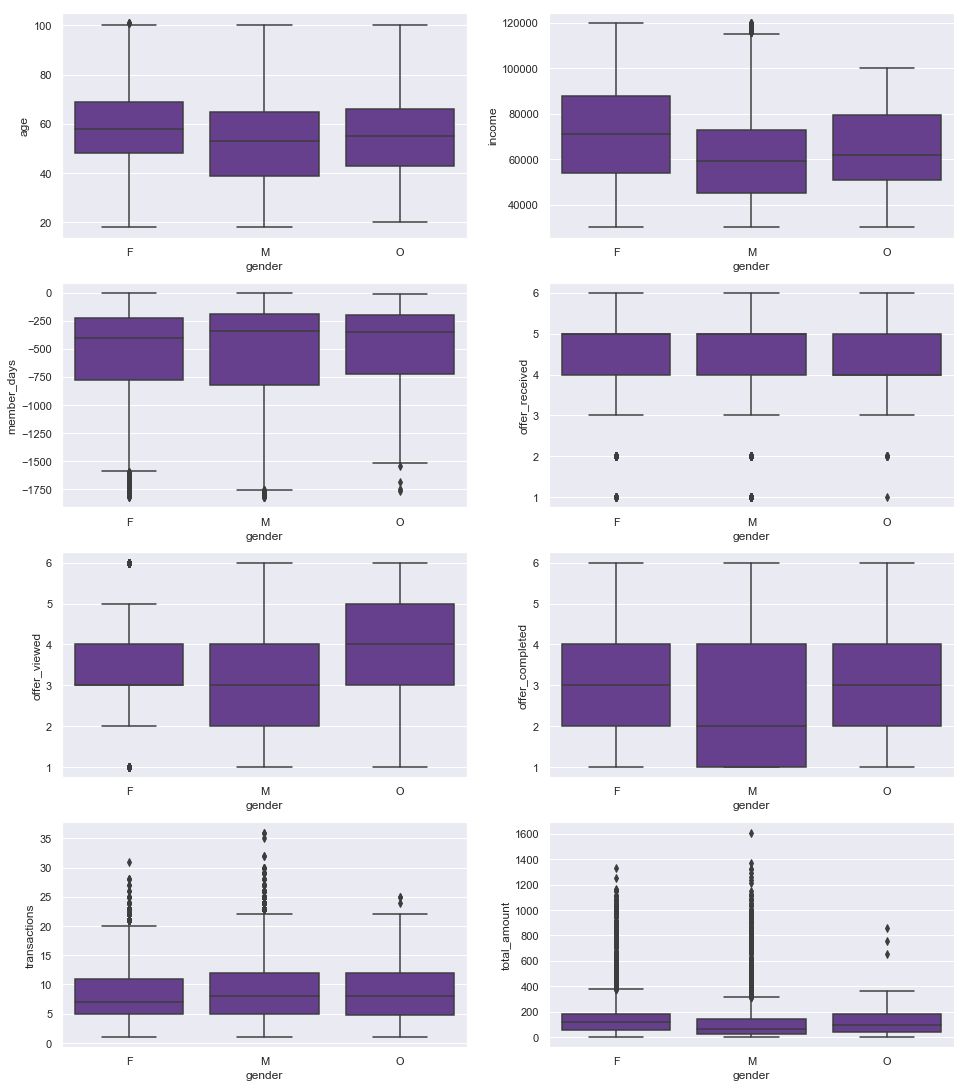

In [42]:
"""show correlation between gender (category) and numerical features""" # note gender is missing for 2'175 customers

EDA.plot_num_corrBox(profile, 'gender', figsize=(16, 24))

## Explore transcript data

Focus on transactions.

In [36]:
display(transcript.head())
display(transcript.info())

,event,person_id,time,amount,offer_id,o_1,o_2,o_3,o_4,o_5,o_6,o_7,o_8,o_9,o_10
0,offer received,p_4,0,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,offer viewed,p_4,6,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transaction,p_4,132,19.89,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,p_4,132,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,p_4,144,17.78,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 15 columns):
event        306534 non-null object
person_id    306534 non-null object
time         306534 non-null int64
amount       138953 non-null float64
offer_id     167581 non-null object
o_1          36790 non-null float64
o_2          32185 non-null float64
o_3          30359 non-null float64
o_4          32714 non-null float64
o_5          31399 non-null float64
o_6          39337 non-null float64
o_7          46677 non-null float64
o_8          29930 non-null float64
o_9          19180 non-null float64
o_10         21410 non-null float64
dtypes: float64(11), int64(1), object(3)
memory usage: 35.1+ MB


None

In [37]:
# count total number of transactions

total_transactions = transcript['event'].value_counts()[0]
print("total number of transactions: ", total_transactions)

total number of transactions:  138953


In [38]:
# check how many transactions are assigned (flagged) to how many promotions each

assert transcript.columns[-10] == 'o_1' # safety-check
transcript['promo_count'] = transcript.iloc[: , -10:].count(axis=1)
transcript.loc[transcript['event'] == 'transaction']['promo_count'].value_counts()

1    87847
2    30719
0    18760
3     1627
Name: promo_count, dtype: int64